In [28]:
import datetime as dt
from pytz import timezone
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import HTML
from money_squirrel.bin import utils

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

COINS = utils.load_config("coins")

def display_all(df):
    return HTML(df.to_html())

2017-06-26 05:53:15,738|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/coins.json


In [3]:
gdax_price = utils.query_pg("select * from gdax_quote")

2017-06-26 05:30:16,868|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-06-26 05:30:16,869|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-06-26 05:30:16,874|money_squirrel.bin.utils|INFO|Executing query:

select * from gdax_quote



In [4]:
gdax_price.head()

,id,product,granularity,dt,low,high,open,close,volume
0,1,BTC-USD,20,2017-04-18 00:58:00-07:00,1197.77,1197.82,1197.82,1197.77,0.309400
1,2,BTC-USD,20,2017-04-18 00:57:00-07:00,1197.82,1197.83,1197.83,1197.83,1.215607
2,3,BTC-USD,20,2017-04-18 00:56:00-07:00,1196.32,1198.00,1198.00,1197.95,10.995732
3,4,BTC-USD,20,2017-04-18 00:55:00-07:00,1197.99,1198.00,1198.00,1197.99,4.106907
4,5,BTC-USD,20,2017-04-18 00:54:00-07:00,1197.99,1198.00,1198.00,1198.00,4.394364


In [5]:
gdax_price['granularity'].value_counts()

20    1448205
60     232149
Name: granularity, dtype: int64

In [8]:
gdax_price.loc[0, 'dt'].__class__

pandas.tslib.Timestamp

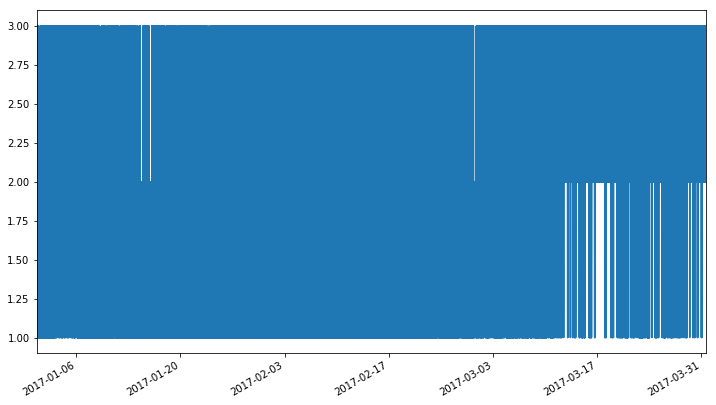

In [12]:
gdax_price.loc[gdax_price['granularity']==60, 'dt'].value_counts().plot()

In [29]:
gdax_price.loc[gdax_price['granularity']==60, 'dt'].max().replace(tzinfo=timezone('UTC'))

datetime.datetime(2017, 3, 31, 16, 59, tzinfo=<UTC>)

In [20]:
gdax_price.dt.isnull().value_counts()

False    1680354
Name: dt, dtype: int64